# Fama-French 3 Factor Model

The Fama-French Three-Factor Model is a widely used tool in finance to analyze the performance of stocks and portfolios. It decomposes the returns of a stock or portfolio into three factors: market excess returns, company size, and value by conducting an Ordinary Least Squares (OLS) regression analysis .

The Fama-French Factor Model is a way to determine what factors influence returns. Returns could be the return of a single stock, a portfolio of multiple stocks or a specific index such as the SP500. It can be applied to individual stocks, portfolios of stocks, mutual funds, or any other type of investment that can be compared to the broader market.

Originally, the model started with three factors, also known as the Fama-French three-factor model. These factors are:

- Market excess returns (Mkt-RF): The return of the SP500 index minus the risk-free rate. This factor captures the overall market movement.
- Size factor (SMB, Small Minus Big): The return of small-cap stocks minus the return of large-cap stocks. This factor captures the outperformance of small-cap stocks over large-cap stocks.
- Value factor (HML, High Minus Low): The return of value stocks minus the return of growth stocks. This factor captures the outperformance of value stocks over growth stocks.

In order to determine the sentivity and explanatory power of each factor on the portfolio's return, a simple linear regression model is used.

# Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

style.use("default")

params = {
    "axes.labelsize": 8, "font.size": 8, "legend.fontsize": 8,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "text.usetex": False,
    "font.family": "sans-serif", "axes.spines.top": False, "axes.spines.right": False,
    "grid.color": "grey", "axes.grid": True,  "grid.alpha": 0.5, "grid.linestyle": ":",
}

plt.rcParams.update(params)

In [2]:
tickers = [
    "AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "TSLA", "BRK-B", "JNJ", "WMT", "JPM",
    "V", "PG", "UNH", "HD", "BAC", "MA", "DIS", "XOM", "KO", "PFE",
    "CVX", "MRK", "PEP", "ABBV", "TMO", "LLY", "AVGO", "CSCO", "COST", "DHR",
    "ACN", "MCD", "NKE", "WFC", "NEE", "INTC", "TXN", "LIN", "MDT", "HON",
    "LOW", "PM", "IBM", "UPS", "QCOM", "AMGN", "ORCL", "RTX", "NFLX", "BA"
]
# tickers=["AAPL","MSFT","AMZN","NVDA","JNJ","PFE","UNH","JPM","BAC","MS","GS","TSLA","HD","PG","KO","PEP"]

# tickers=["MSFT","AMZN","AAPL","NVDA","BRK-B","GS","MS","NAT","BAC","DPZ","DIS","KO","MCD","COST","SBUX"]

portfolio_monthly=yf.download(tickers,period="max",interval="1mo")["Close"].pct_change()*100
# portfolio_monthly=yf.download(tickers,start="2006-01-01",end="2023-12-31",interval="1mo")["Close"].pct_change()*100
portfolio_monthly.dropna(inplace=True)
portfolio_monthly.index = portfolio_monthly.index.strftime('%Y-%m')

portfolio_monthly.index = pd.to_datetime(portfolio_monthly.index).to_period("M")

portfolio_monthly

[*********************100%***********************]  50 of 50 completed


Ticker,AAPL,ABBV,ACN,AMGN,AMZN,AVGO,BA,BAC,BRK-B,COST,...,RTX,TMO,TSLA,TXN,UNH,UPS,V,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2013-02,-3.093326,1.824758,3.435805,7.126131,-0.463274,-4.333261,4.101800,-0.795050,5.395650,-1.025962,...,3.402994,2.301085,-7.144776,4.746769,-3.187824,4.237624,0.462299,1.436755,1.186578,-0.466807
2013-03,0.869911,10.455044,2.165091,12.581394,0.840050,4.967887,12.355573,8.557047,1.996861,5.038218,...,3.797721,3.644951,8.785529,3.049656,7.034638,4.706853,7.285841,5.444772,5.721910,1.268247
2013-04,0.027098,12.922994,7.200210,1.658398,-4.758151,-10.551476,6.476420,1.067284,2.034552,2.186390,...,-2.290504,5.681895,42.491410,2.057471,5.161015,-0.069859,-0.812535,2.676327,4.532202,-1.242982
2013-05,1.569651,-6.438420,1.905828,-3.531380,6.063589,18.053775,8.325104,10.966690,7.289315,1.106690,...,3.954432,9.444693,81.070575,-0.053457,4.505245,0.069908,5.746202,6.766756,-3.705651,1.663137
2013-06,-11.245706,-3.162342,-12.361463,-1.426663,3.153785,-0.927653,3.985916,-5.856514,-1.884809,1.138932,...,-1.516072,-4.156239,9.819966,-2.951841,4.550552,1.381211,2.775931,2.576943,0.129323,0.558177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03,-8.049024,0.234419,-10.461978,1.949951,-10.373094,-16.045734,-2.336369,-9.479393,3.649067,-9.706657,...,0.105566,-5.928613,-11.543452,-8.311652,10.272457,-6.272114,-3.214777,-7.885050,-10.972511,7.782078
2025-04,-4.335298,-6.882401,-4.130887,-6.621729,-3.069482,15.303364,7.440635,-3.830154,0.125799,5.151298,...,-4.778815,-13.713268,8.874826,-10.934894,-21.107719,-13.355755,-1.415276,-1.086499,11.079909,-11.183046
2025-05,-5.482356,-3.726326,6.431911,-0.941842,11.164731,25.770252,13.141236,10.656970,-5.492735,4.593268,...,8.205816,-6.102564,22.788484,15.220233,-26.621140,2.350464,5.698986,5.309108,1.511575,-3.152510


# Calculate the Fama-French Factors


F-F Research Factors Data Link -> https://drive.google.com/file/d/1IKrtOS3ePEJ_WLovEP1KMdq8nD_qmJ6a/view?usp=sharing

In [8]:
ff_factors_monthly =pd.read_csv("/content/F-F_Research_Data_Factors.csv",index_col=0)
ff_factors_monthly.index.names=["Date"]
ff_factors_monthly.index=pd.to_datetime(ff_factors_monthly.index,format="%Y%m")
ff_factors_monthly.index=ff_factors_monthly.index.to_period("M")
ff_factors_monthly

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31
...,...,...,...,...
2024-03,2.83,-2.51,4.21,0.43
2024-04,-4.67,-2.39,-0.52,0.47
2024-05,4.34,0.78,-1.66,0.44


In [9]:
# Filter factor dates to match the asset
ff_factors_subset=ff_factors_monthly[ff_factors_monthly.index.isin(portfolio_monthly.index)].copy()

# Calculate returns for the asset

ff_factors_subset=pd.concat([ff_factors_subset,portfolio_monthly],axis=1)
ff_factors_subset.dropna(inplace=True)

ff_factors_subset

,Mkt-RF,SMB,HML,RF,AAPL,ABBV,ACN,AMGN,AMZN,AVGO,...,RTX,TMO,TSLA,TXN,UNH,UPS,V,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2013-02,1.29,-0.27,0.11,0.00,-3.093326,1.824758,3.435805,7.126131,-0.463274,-4.333261,...,3.402994,2.301085,-7.144776,4.746769,-3.187824,4.237624,0.462299,1.436755,1.186578,-0.466807
2013-03,4.03,0.81,-0.19,0.00,0.869911,10.455044,2.165091,12.581394,0.840050,4.967887,...,3.797721,3.644951,8.785529,3.049656,7.034638,4.706853,7.285841,5.444772,5.721910,1.268247
2013-04,1.55,-2.37,0.45,0.00,0.027098,12.922994,7.200210,1.658398,-4.758151,-10.551476,...,-2.290504,5.681895,42.491410,2.057471,5.161015,-0.069859,-0.812535,2.676327,4.532202,-1.242982
2013-05,2.80,1.71,2.63,0.00,1.569651,-6.438420,1.905828,-3.531380,6.063589,18.053775,...,3.954432,9.444693,81.070575,-0.053457,4.505245,0.069908,5.746202,6.766756,-3.705651,1.663137
2013-06,-1.20,1.33,0.03,0.00,-11.245706,-3.162342,-12.361463,-1.426663,3.153785,-0.927653,...,-1.516072,-4.156239,9.819966,-2.951841,4.550552,1.381211,2.775931,2.576943,0.129323,0.558177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03,2.83,-2.51,4.21,0.43,-5.007570,3.436532,-7.516407,4.642545,2.047981,1.916197,...,9.481525,1.934483,-12.923524,4.111637,0.222846,1.373797,-1.075427,4.995693,2.661653,12.246737
2024-04,-4.67,-2.39,-0.52,0.47,-0.670624,-10.686448,-13.184858,-3.650818,-2.982595,-1.478972,...,4.091042,-2.084608,4.260769,1.268585,-1.838130,-0.773738,-3.751605,2.346442,-1.026866,1.746391
2024-05,4.34,0.78,-1.66,0.44,12.869124,0.065074,-5.824643,11.648535,0.822859,2.174939,...,6.195837,-0.130112,-2.837187,10.537348,2.412651,-5.797401,1.433294,1.011453,10.800353,-0.853975


# Regression Model (Fama French 3 factor model)


In [10]:
rf=ff_factors_subset['RF']/100
returns=ff_factors_subset.iloc[:,4:]/100 # Dataframe of Returns for each stock
market=ff_factors_subset['Mkt-RF']/100 # Market return
smb=ff_factors_subset['SMB']/100 # SMB factor
hml=ff_factors_subset['HML']/100 # HML factor

In [ ]:
print(returns.isna().sum())
print(market.isna().sum())
print(smb.isna().sum())
print(hml.isna().sum())
print(rf.isna().sum())

AAPL     0
ABBV     0
ACN      0
AMGN     0
AMZN     0
AVGO     0
BA       0
BAC      0
BRK-B    0
COST     0
CSCO     0
CVX      0
DHR      0
DIS      0
GOOGL    0
HD       0
HON      0
IBM      0
INTC     0
JNJ      0
JPM      0
KO       0
LIN      0
LLY      0
LOW      0
MA       0
MCD      0
MDT      0
MRK      0
MSFT     0
NEE      0
NFLX     0
NKE      0
NVDA     0
ORCL     0
PEP      0
PFE      0
PG       0
PM       0
QCOM     0
RTX      0
TMO      0
TSLA     0
TXN      0
UNH      0
UPS      0
V        0
WFC      0
WMT      0
XOM      0
dtype: int64
0
0
0
0


In [11]:
print(returns.shape, market.shape, smb.shape, hml.shape, rf.shape)

(138, 50) (138,) (138,) (138,) (138,)


In [14]:
# Fama-French regression

def fama_french_regression(returns,market,smb,hml,rf):
    X=sm.add_constant(pd.concat([market,smb,hml],axis=1))
    betas=[]
    for stock in returns.columns:
        Y=returns[stock]-rf
        model=sm.OLS(Y,X).fit()
        betas.append(model.params.values)
    betas_df=pd.DataFrame(betas,columns=['alpha','beta_mkt','beta_smb','beta_hml'],index=returns.columns)
    return betas_df,model

betas,model=fama_french_regression(returns,market,smb,hml,rf)

In [15]:
betas

,alpha,beta_mkt,beta_smb,beta_hml
AAPL,0.007955,1.250939,-0.266892,-0.520495
ABBV,0.009087,0.754001,0.002351,0.220757
ACN,0.000754,1.148768,-0.213471,-0.242000
AMGN,0.005370,0.727237,-0.205868,0.020113
AMZN,0.006405,1.326237,-0.248815,-0.952880
AVGO,0.020619,1.082522,0.035603,-0.276498
BA,-0.001069,1.373965,0.277837,0.435233
BAC,0.000364,1.321371,0.168434,0.996414
BRK-B,0.001554,0.886301,-0.498417,0.375019
COST,0.007872,0.813390,-0.245373,-0.437781


In [16]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     44.79
Date:                Sun, 06 Jul 2025   Prob (F-statistic):           4.09e-20
Time:                        15:49:58   Log-Likelihood:                 210.31
No. Observations:                 138   AIC:                            -412.6
Df Residuals:                     134   BIC:                            -400.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.005     -0.179      0.8

### So  now we can see the risk involved with investing in these firms by looking at its coefficients and draw the plot 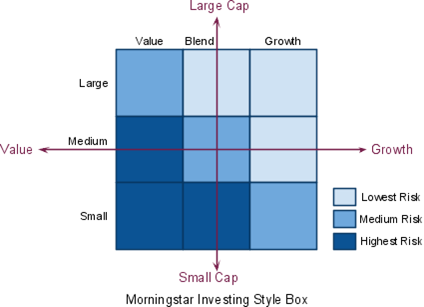

Plots

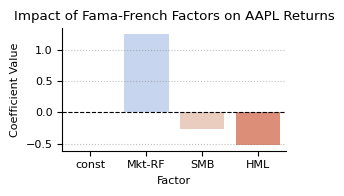

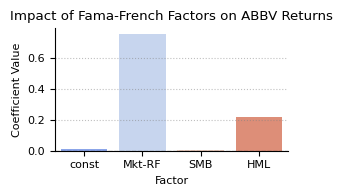

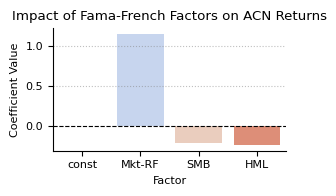

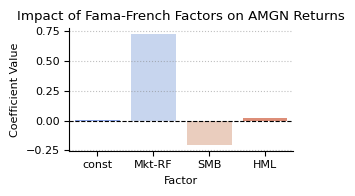

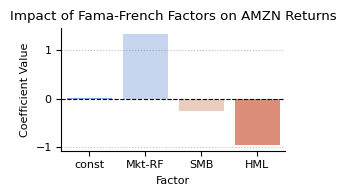

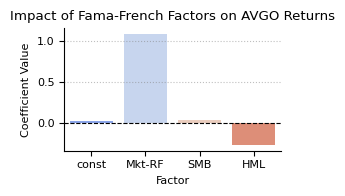

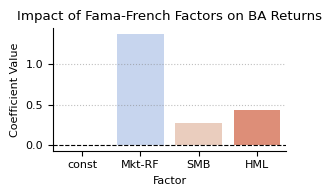

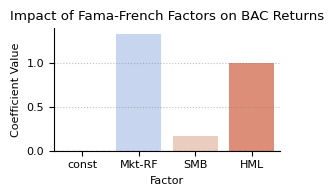

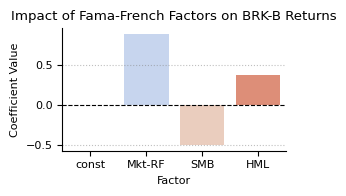

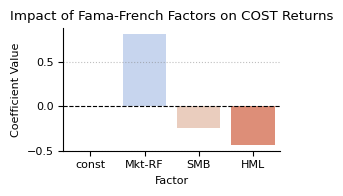

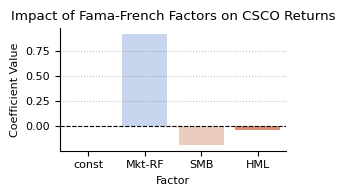

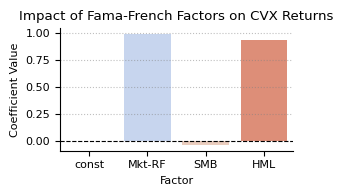

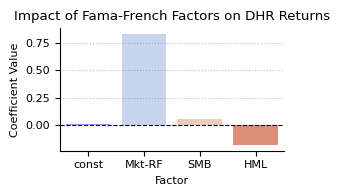

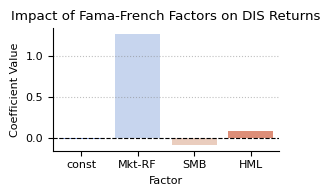

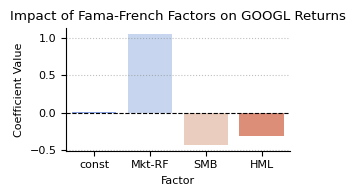

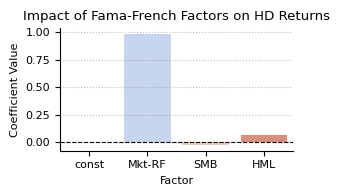

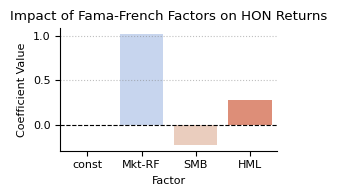

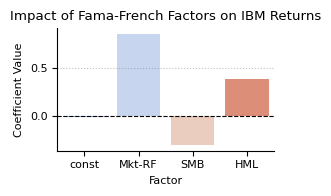

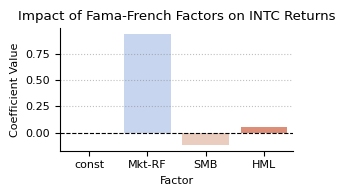

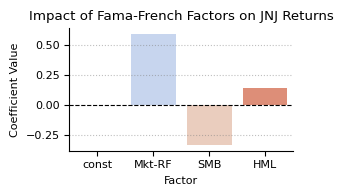

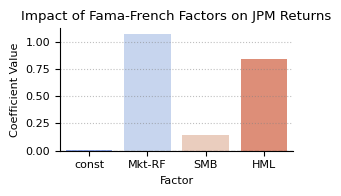

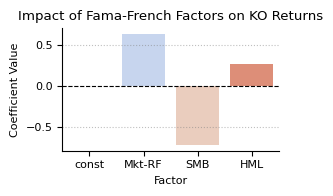

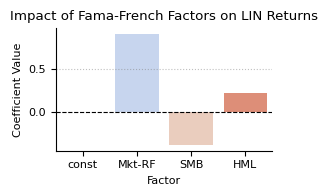

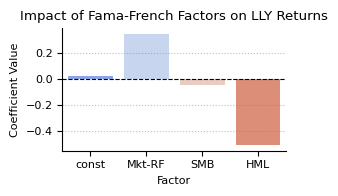

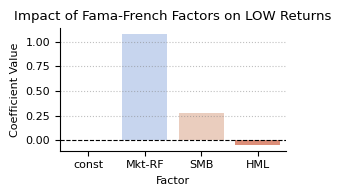

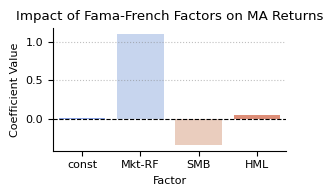

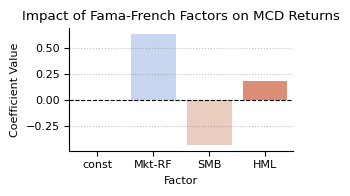

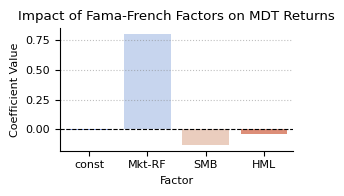

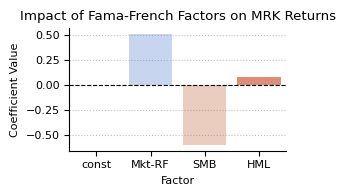

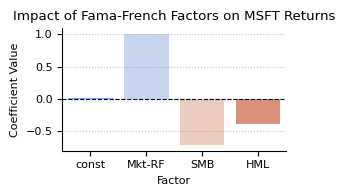

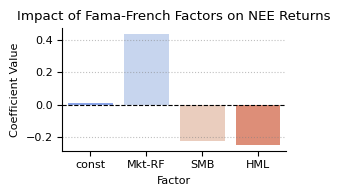

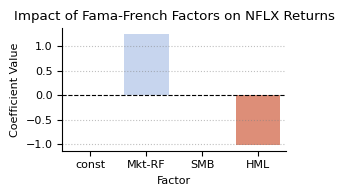

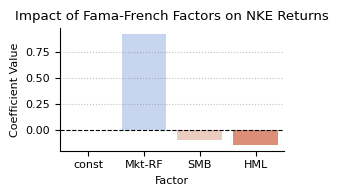

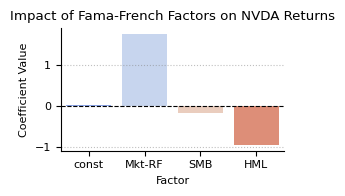

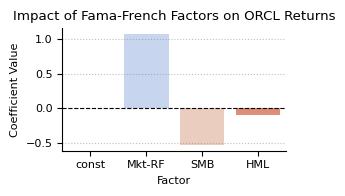

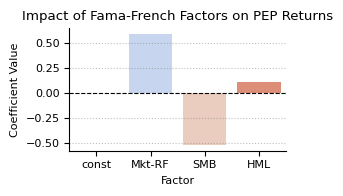

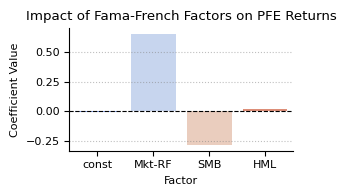

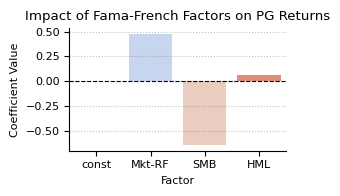

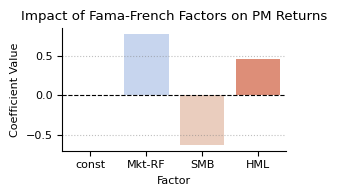

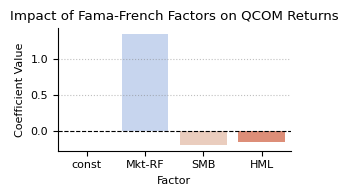

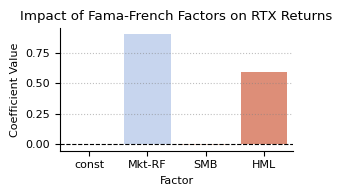

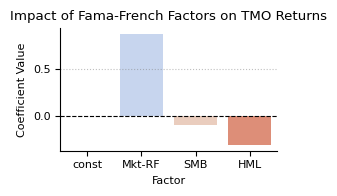

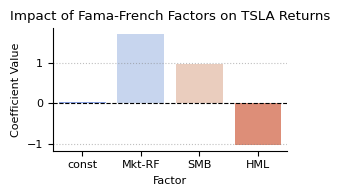

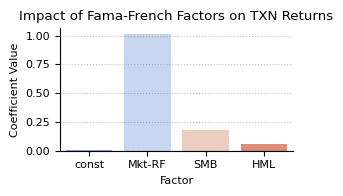

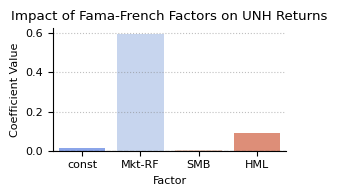

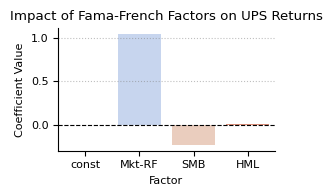

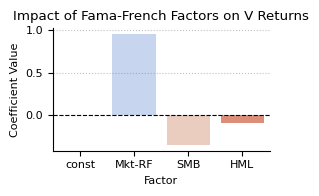

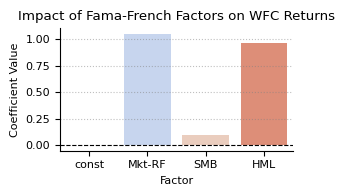

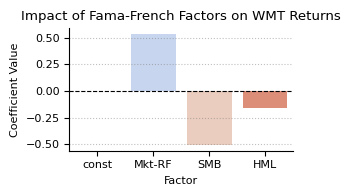

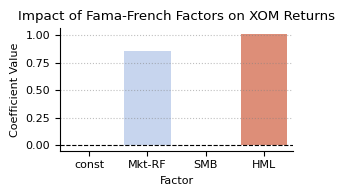

In [17]:
def fama_french_regression(returns, market, smb, hml, rf):
    X = sm.add_constant(pd.concat([market, smb, hml], axis=1))
    betas=[]
    models={}

    for stock in returns.columns:
        Y=returns[stock]-rf
        model=sm.OLS(Y,X).fit()
        betas.append(model.params.values)
        models[stock]=model  # Save the model for each stock

    return pd.DataFrame(betas,columns=['alpha','beta_mkt','beta_smb','beta_hml'],index=returns.columns),models

betas,models=fama_french_regression(returns,market,smb,hml,rf)

# Plotting for each stock
for stock in returns.columns:
    model=models[stock]

    # Data preparation for plotting
    factors=model.params.index
    coefficients=model.params.values
    confidence_intervals=model.conf_int().diff(axis=1).iloc[1]

    ols_data=pd.DataFrame({
        "Factor":factors,
        "Coefficient":coefficients,
        "Confidence_Lower":confidence_intervals[0],
        "Confidence_Upper":confidence_intervals[1],
    })

    # Plotting
    plt.figure(figsize=(3,2))  # Adjust figure size
    sns.barplot(x="Factor",y="Coefficient",data=ols_data,capsize=0.2,palette="coolwarm")

    # Adding the p-value for each factor to the plot
    # for i,row in ols_data.iterrows():
    #     plt.text(
    #         i,
    #         0.2,
    #         f"p-value:\n{model.pvalues[row['Factor']]:.4f}",
    #         ha="center",
    #         va="bottom",
    #         fontsize=6,
    #     )

    # Customize plot
    plt.title(f"Impact of Fama-French Factors on {stock} Returns")
    plt.xlabel("Factor")
    plt.ylabel("Coefficient Value")
    plt.axhline(0,color="black",linewidth=0.8,linestyle="--")

    # Show each plot
    plt.tight_layout()
    plt.show()
    print("\n")

# Black Litterman Model

In [18]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 10.5 MB/s eta 0:00:00


In [19]:
tickers = [
    "AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "TSLA", "BRK-B", "JNJ", "WMT", "JPM",
    "V", "PG", "UNH", "HD", "BAC", "MA", "DIS", "XOM", "KO", "PFE",
    "CVX", "MRK", "PEP", "ABBV", "TMO", "LLY", "AVGO", "CSCO", "COST", "DHR",
    "ACN", "MCD", "NKE", "WFC", "NEE", "INTC", "TXN", "LIN", "MDT", "HON",
    "LOW", "PM", "IBM", "UPS", "QCOM", "AMGN", "ORCL", "RTX", "NFLX", "BA"
]

# tickers=["AAPL","MSFT","AMZN","NVDA","JNJ","PFE","UNH","JPM","BAC","MS","GS","TSLA","HD","PG","KO","PEP"]

# tickers=["MSFT","AMZN","AAPL","NVDA","BRK-B","GS","MS","NAT","BAC","DPZ","DIS","KO","MCD","COST","SBUX"]

In [20]:
ohlc=yf.download(tickers,period="max")
# ohlc=yf.download(tickers,period="max",interval="1mo")
# ohlc=yf.download(tickers,start="2006-01-01",end="2023-12-31",interval="1mo")

prices=ohlc["Close"]
# prices=ohlc["Close"].pct_change()*100

prices.dropna(inplace=True)

prices.index = prices.index.strftime('%Y-%m-%d')
# prices.index = pd.to_datetime(prices.index).to_period("M")

prices

[*********************100%***********************]  50 of 50 completed


Ticker,AAPL,ABBV,ACN,AMGN,AMZN,AVGO,BA,BAC,BRK-B,COST,...,RTX,TMO,TSLA,TXN,UNH,UPS,V,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,16.647186,21.230917,55.219437,63.486420,12.865500,2.376472,64.583847,9.550556,93.199997,80.215454,...,39.318684,62.242352,2.357333,22.973303,44.852055,50.495289,35.549843,24.595968,17.898842,53.340279
2013-01-03,16.437056,21.055599,55.019569,63.087612,12.924000,2.388888,64.919060,9.494985,93.620003,81.037781,...,39.463806,62.050850,2.318000,22.674679,42.754993,50.541599,35.577293,24.392466,17.785091,53.244061
2013-01-04,15.979212,20.789608,55.323402,63.365364,12.957500,2.373550,65.103416,9.614072,93.849998,80.776833,...,39.777416,62.596676,2.293333,22.624908,42.837242,50.667336,35.867870,24.518772,17.852303,53.490582
2013-01-07,15.885214,20.831926,55.083534,63.044876,13.423000,2.360405,63.796124,9.598193,93.449997,80.152222,...,39.585495,63.085045,2.289333,22.695995,42.837242,50.521759,36.124119,24.399485,17.681692,52.871269
2013-01-08,15.927968,20.378529,55.403362,62.774311,13.319000,2.344338,62.120155,9.510860,93.809998,80.001976,...,39.108059,62.692421,2.245333,22.432924,42.269791,50.382790,36.460453,24.357376,17.730803,53.201981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,201.080002,182.309998,295.459991,277.130005,223.300003,269.350006,214.550003,47.119999,485.679993,985.140015,...,144.660004,408.279999,323.630005,207.080002,309.109985,101.180000,348.609985,79.500000,97.269997,109.379997
2025-06-30,205.169998,185.619995,298.890015,279.209991,219.389999,275.649994,209.529999,47.320000,485.769989,989.940002,...,146.020004,405.459991,317.660004,207.619995,311.970001,100.940002,355.049988,80.120003,97.779999,107.800003
2025-07-01,207.820007,189.990005,302.619995,290.519989,220.460007,264.739990,209.789993,48.150002,489.609985,985.960022,...,144.190002,421.470001,300.709991,210.449997,326.140015,104.470001,355.470001,81.489998,98.239998,109.239998


In [21]:
market_prices=yf.download("SPY",period="max")["Close"]
# market_prices=yf.download("SPY",period="max",interval="1mo")["Close"]
# market_prices=yf.download("SPY",start="2006-01-01",end="2023-12-31",interval="1mo")["Close"]
# market_prices=yf.download("SPY",start="2006-01-01",end="2023-12-31",interval="1mo")["Close"].pct_change()*100

market_prices.dropna(inplace=True)

# market_prices.index = market_prices.index.strftime('%Y-%m')
# market_prices.index = pd.to_datetime(market_prices.index).to_period("M")
market_prices=market_prices[market_prices.index.isin(prices.index)].copy()

market_prices

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2013-01-02,117.278152
2013-01-03,117.013161
2013-01-04,117.527061
2013-01-07,117.205887
2013-01-08,116.868629
...,...
2025-06-27,614.909973
2025-06-30,617.849976
2025-07-01,617.650024


In [22]:
mcaps={}
for t in tickers:
    stock=yf.Ticker(t)
    mcaps[t]=stock.info["marketCap"]
mcaps

{'AAPL': 3189540126720,
 'MSFT': 3707648344064,
 'AMZN': 2371809968128,
 'NVDA': 3885920157696,
 'GOOGL': 2184126005248,
 'TSLA': 1015729750016,
 'BRK-B': 1046280798208,
 'JNJ': 375370973184,
 'WMT': 784954097664,
 'JPM': 822610624512,
 'V': 701033021440,
 'PG': 377072353280,
 'UNH': 279898030080,
 'HD': 369794842624,
 'BAC': 368534880256,
 'MA': 516916576256,
 'DIS': 222920998912,
 'XOM': 483541614592,
 'KO': 307109658624,
 'PFE': 144294674432,
 'CVX': 257010958336,
 'MRK': 203217666048,
 'PEP': 185616809984,
 'ABBV': 334344192000,
 'TMO': 162069495808,
 'LLY': 700835561472,
 'AVGO': 1294300872704,
 'CSCO': 274705203200,
 'COST': 437720678400,
 'DHR': 145424138240,
 'ACN': 189833134080,
 'MCD': 210276909056,
 'NKE': 112750878720,
 'WFC': 272049455104,
 'NEE': 152091574272,
 'INTC': 98101379072,
 'TXN': 196248125440,
 'LIN': 223866912768,
 'MDT': 113250574336,
 'HON': 154638991360,
 'LOW': 127953600512,
 'PM': 278430285824,
 'IBM': 271356035072,
 'UPS': 88177074176,
 'QCOM': 1781065809

# Portfolio Allocation Functions
Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers.

In [23]:
from pypfopt import EfficientFrontier,objective_functions
from pypfopt import DiscreteAllocation
from pypfopt import expected_returns,risk_models

In [24]:
initial_capital=100000

In [25]:
def calculate_weights(ret_bt,S_bl):
  ef=EfficientFrontier(ret_bl,S_bl)
  ef.add_objective(objective_functions.L2_reg)
  ef.max_sharpe()
  weights=ef.clean_weights()
  return weights

weights is the fractional allocation of capital to each asset, where the weights sum up to 1

In [26]:
def plot_weights(weights,mcaps):
  mcaps_series=pd.Series(mcaps)
  market_cap_weights=mcaps_series/mcaps_series.sum()

  weights_df=pd.DataFrame({
      'Market Cap Weights':market_cap_weights,
      'Optimal Weights':weights
  })

  weights_df.plot(kind='bar',figsize=(12,6))
  plt.title('Market Cap Weights vs Optimal Weights')
  plt.ylabel('Weights')
  plt.xlabel('Stocks')
  plt.xticks(rotation=45)
  plt.legend(loc='upper left')
  plt.grid(axis='y')
  plt.tight_layout()
  plt.show()

In [27]:
def plot_pie(weights):
  pd.Series(weights).plot.pie(figsize=(10,10));

alloc: Dictionary of allocated shares for each asset, showing how many shares of each asset should be purchased to meet the portfolio allocation as closely as possible.

In [28]:
def discrete_allocation(weights):
  da=DiscreteAllocation(weights,prices.iloc[-1],total_portfolio_value=initial_capital)
  alloc, leftover=da.lp_portfolio()

  for stock in weights:
      if stock not in alloc:
          alloc[stock] = 0

  # print(f"Leftover:${leftover:.2f}")
  return alloc,leftover

In [29]:
def calculate_performance(alloc,prices):

  # Step 1: Calculate the expected portfolio return
  # Calculate expected annual returns for each stock
  daily_returns=prices.copy()
  daily_returns=daily_returns.pct_change()
  daily_returns.dropna(inplace=True)
  mean_daily_returns=daily_returns.mean()
  mean_annual_returns=mean_daily_returns*252
  expected_annual_returns=mean_annual_returns

  # Calculate the expected return of your final portfolio
  portfolio_return=((sum([prices.iloc[-1][stock]*alloc[stock]*expected_annual_returns[stock] for stock in alloc.keys()]))/initial_capital)*100

  # Step 2: Calculate the portfolio volatility (standard deviation)
  # Calculate the sample covariance matrix of the asset returns
  cov_matrix=risk_models.sample_cov(daily_returns)

  # Convert allocation to weights (as percentages of the total portfolio value)
  portfolio_weights={stock:(alloc[stock]*prices.iloc[-1][stock])/initial_capital for stock in alloc.keys()}

  # Create a list of weights matching the order of expected returns
  weights_array=[portfolio_weights[stock] for stock in expected_annual_returns.index if stock in portfolio_weights]

  # Calculate portfolio variance
  portfolio_variance=np.dot(weights_array,np.dot(cov_matrix,weights_array))

  # Calculate portfolio volatility (standard deviation)
  portfolio_volatility=np.sqrt(portfolio_variance)

  # Step 3: Calculate the Sharpe ratio
  # Assuming risk-free rate is 0 for simplicity, you can adjust this if needed
  risk_free_rate=2
  sharpe_ratio=(portfolio_return-risk_free_rate)/portfolio_volatility

  # Output the results
  print(f"Expected Portfolio Return: {portfolio_return:.2f}%")
  print(f"Portfolio Volatility: {portfolio_volatility:.2f}")
  print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

In [30]:
import pypfopt
pypfopt.__version__

'1.5.6'

**Purpose of the Code**

Covariance Matrix (S): The Ledoit-Wolf shrinkage provides a stable estimate of how different assets move relative to each other (covariances), which is crucial for portfolio optimization.

Risk aversion reflects how much an investor dislikes risk. In the Black-Litterman model, the parameter delta quantifies how sensitive the investor (or market) is to risk. A higher value of delta means higher aversion to risk, leading to more conservative portfolio allocations.

Risk Aversion (delta): The market's risk aversion is calculated to adjust the market's expected returns based on the Black-Litterman model. This adjustment allows the portfolio to account for market sentiment and investor preferences toward risk.

In summary, the code is preparing two key inputs for constructing a portfolio using the Black-Litterman model: a covariance matrix and the market-implied risk aversion. These inputs will later be used to determine the optimal asset allocation by combining market data with investor views

In [31]:
from pypfopt import black_litterman,risk_models
from pypfopt import BlackLittermanModel,plotting

S=risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta=black_litterman.market_implied_risk_aversion(market_prices,frequency=252)
delta

np.float64(5.078365251750173)

<Figure size 10000x10000 with 0 Axes>

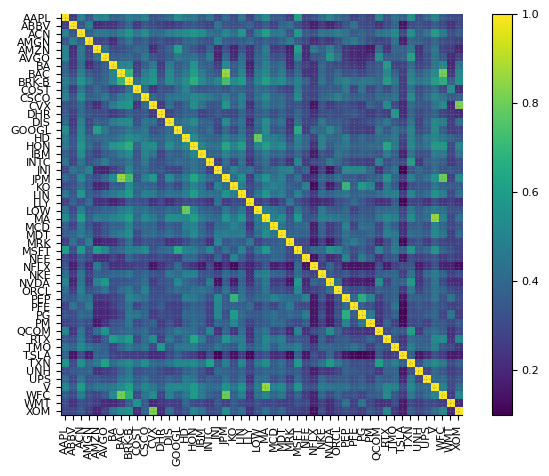

In [32]:
plt.figure(figsize=(100,100))
plotting.plot_covariance(S,plot_correlation=True);
plt.show()

**Purpose of the Code**

This code computes the equilibrium (or prior) returns implied by market capitalization weights. These returns are based on the assumption that the market portfolio is "mean-variance efficient," i.e., the market prices reflect a balance between risk and return for the assets under consideration.

In [33]:
market_prior=black_litterman.market_implied_prior_returns(mcaps,delta,S)
market_prior

,0
Ticker,
AAPL,0.226006
ABBV,0.109778
ACN,0.174396
AMGN,0.120769
AMZN,0.242381
AVGO,0.274107
BA,0.207236
BAC,0.183804
BRK-B,0.130333


These returns are in decimal

The returns calculated by the black_litterman.market_implied_prior_returns function are generally annualized expected returns based on the input data.

The market-implied returns represent the returns that would make the market portfolio optimal under the assumptions of mean-variance efficiency. These returns serve as the "prior" or baseline before incorporating any specific investor views into the Black-Litterman model.

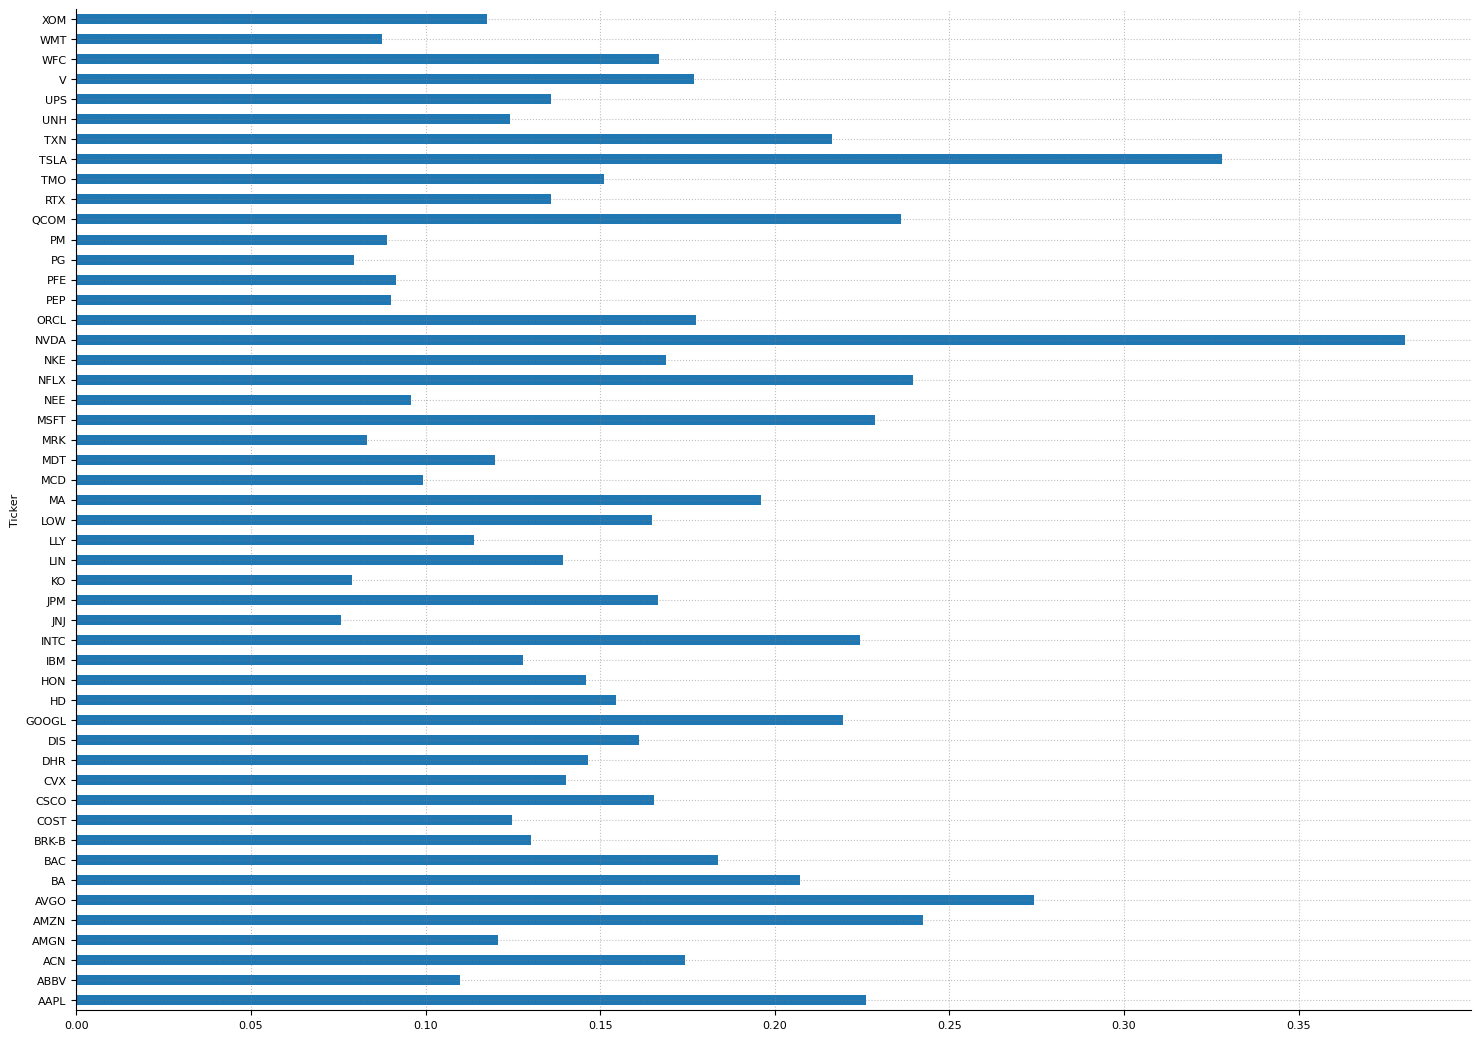

In [34]:
market_prior.plot.barh(figsize=(18,13));

**Investor Views**

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

If we provide absolute views (i.e a return estimate for each asset), we don't have to worry about P and Q, we can just pass our views as a dictionary.

These investor views represent the annual returns of the assets in decimal form

In [35]:
viewdict = {
    "AAPL": 0.25, "MSFT": 0.15, "AMZN": 0.3, "NVDA": 0.6, "GOOGL": 0.4, "TSLA": 0.5,
    "BRK-B": 0.15, "JNJ": 0.04, "WMT": 0.02, "JPM": 0.035, "V": 0.06, "PG": 0.01, "UNH": 0.015,
    "HD": 0.025, "BAC": 0.05, "MA": 0.04, "DIS": 0.08, "XOM": 0.04, "KO": 0.06, "PFE": 0.015,
    "CVX": 0.02, "MRK": 0.035, "PEP": 0.04, "ABBV": 0.07, "TMO": 0.02, "LLY": 0.025, "AVGO": 0.05,
    "CSCO": 0.04, "COST": 0.03, "DHR": 0.03, "ACN": 0.06, "MCD": 0.04, "NKE": 0.05, "WFC": 0.04,
    "NEE": 0.06, "INTC": 0.03, "TXN": 0.02, "LIN": 0.035, "MDT": 0.025, "HON": 0.03,
    "LOW": 0.01, "PM": 0.015, "IBM": 0.15, "UPS": 0.02, "QCOM": 0.25, "AMGN": 0.0025,
    "ORCL": 0.03, "RTX": 0.005, "NFLX": 0.02, "BA": 0.01
}

# viewdict = {
#     "AAPL": 0.4, "MSFT": 0.5, "AMZN": 0.6, "NVDA": 1.5, "GOOGL": 0.7, "TSLA": 0.7,
#     "BRK-B": 0.3, "JNJ": 0.4, "WMT": 0.2, "JPM": 0.35, "V": 0.6, "PG": 0.1, "UNH": 0.15,
#     "HD": 0.25, "BAC": 0.5, "MA": 0.4, "DIS": 0.8, "XOM": 0.9, "KO": 0.6, "PFE": 0.3,
#     "CVX": 0.2, "MRK": 0.35, "PEP": 0.4, "ABBV": 0.7, "TMO": 0.2, "LLY": 0.25, "AVGO": 0.8,
#     "CSCO": 0.4, "COST": 0.7, "DHR": 0.3, "ACN": 0.6, "MCD": 0.4, "NKE": 0.5, "WFC": 0.9,
#     "NEE": 0.6, "INTC": 0.3, "TXN": 0.2, "LIN": 0.35, "MDT": 0.25, "HON": 0.7,
#     "LOW": 0.1, "PM": 0.4, "IBM": 0.3, "UPS": 0.2, "QCOM": 0.5, "AMGN": 0.8,
#     "ORCL": 0.3, "RTX": 0.6, "NFLX": 0.4, "BA": 0.2
# }

# viewdict = {
#     "AAPL": 5, "MSFT": 4, "AMZN": 3, "NVDA": 7, "GOOGL": 7, "TSLA": 1,
#     "BRK-B": 3, "JNJ": 4, "WMT": 2, "JPM": 1, "V": 6, "PG": 1, "UNH": 1,
#     "HD": 2, "BAC": 5, "MA": 5, "DIS": 8, "XOM": 9, "KO": 6, "PFE": 3,
#     "CVX": 2, "MRK": 3, "PEP": 4, "ABBV": 7, "TMO": 2, "LLY": 2, "AVGO": 8,
#     "CSCO": 4, "COST": 7, "DHR": 3, "ACN": 6, "MCD": 4, "NKE": 5, "WFC": 9,
#     "NEE": 6, "INTC": 3, "TXN": 2, "LIN": 3, "MDT": 5, "HON": 7,
#     "LOW": 1, "PM": 4, "IBM": 3, "UPS": 8, "QCOM": 5, "AMGN": 1,
#     "ORCL": 3, "RTX": 2, "NFLX": 5, "BA": 2
# }

# viewdict = {
#     "AAPL": 0.5, "MSFT": 0.4, "AMZN": 0.3, "NVDA": 1.5, "GOOGL": 0.7, "TSLA": 1,
#     "BRK-B": 0.3, "JNJ": 0.4, "WMT": 0.2, "JPM": 0.15, "V": 0.6, "PG": 0.01, "UNH": 0.015,
#     "HD": 0.025, "BAC": 0.05, "MA": 0.5, "DIS": 0.08, "XOM": 0.09, "KO": 0.06, "PFE": 0.03,
#     "CVX": 0.02, "MRK": 0.035, "PEP": 0.04, "ABBV": 0.07, "TMO": 0.02, "LLY": 0.025, "AVGO": 0.8,
#     "CSCO": 0.4, "COST": 0.07, "DHR": 0.03, "ACN": 0.06, "MCD": 0.04, "NKE": 0.05, "WFC": 0.09,
#     "NEE": 0.06, "INTC": 0.03, "TXN": 0.2, "LIN": 0.35, "MDT": 0.25, "HON": 0.07,
#     "LOW": 0.01, "PM": 0.04, "IBM": 0.3, "UPS": 0.08, "QCOM": 0.5, "AMGN": 0.1,
#     "ORCL": 0.3, "RTX": 0.02, "NFLX": 0.5, "BA": 0.2
# }

bl=BlackLittermanModel(S,pi=market_prior,absolute_views=viewdict)

In [36]:
K=len(viewdict)
K

50

In [37]:
# Posterior estimate of returns
ret_bl=bl.bl_returns()

In [38]:
rets_df=pd.DataFrame([market_prior, ret_bl,pd.Series(viewdict)],
             index=["Prior","Posterior","Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.226006,0.193180,0.2500
ABBV,0.109778,0.048467,0.0700
ACN,0.174396,0.083562,0.0600
AMGN,0.120769,0.032391,0.0025
AMZN,0.242381,0.238389,0.3000
AVGO,0.274107,0.148404,0.0500
BA,0.207236,0.067065,0.0100
BAC,0.183804,0.065485,0.0500
BRK-B,0.130333,0.072283,0.1500
COST,0.124738,0.059131,0.0300


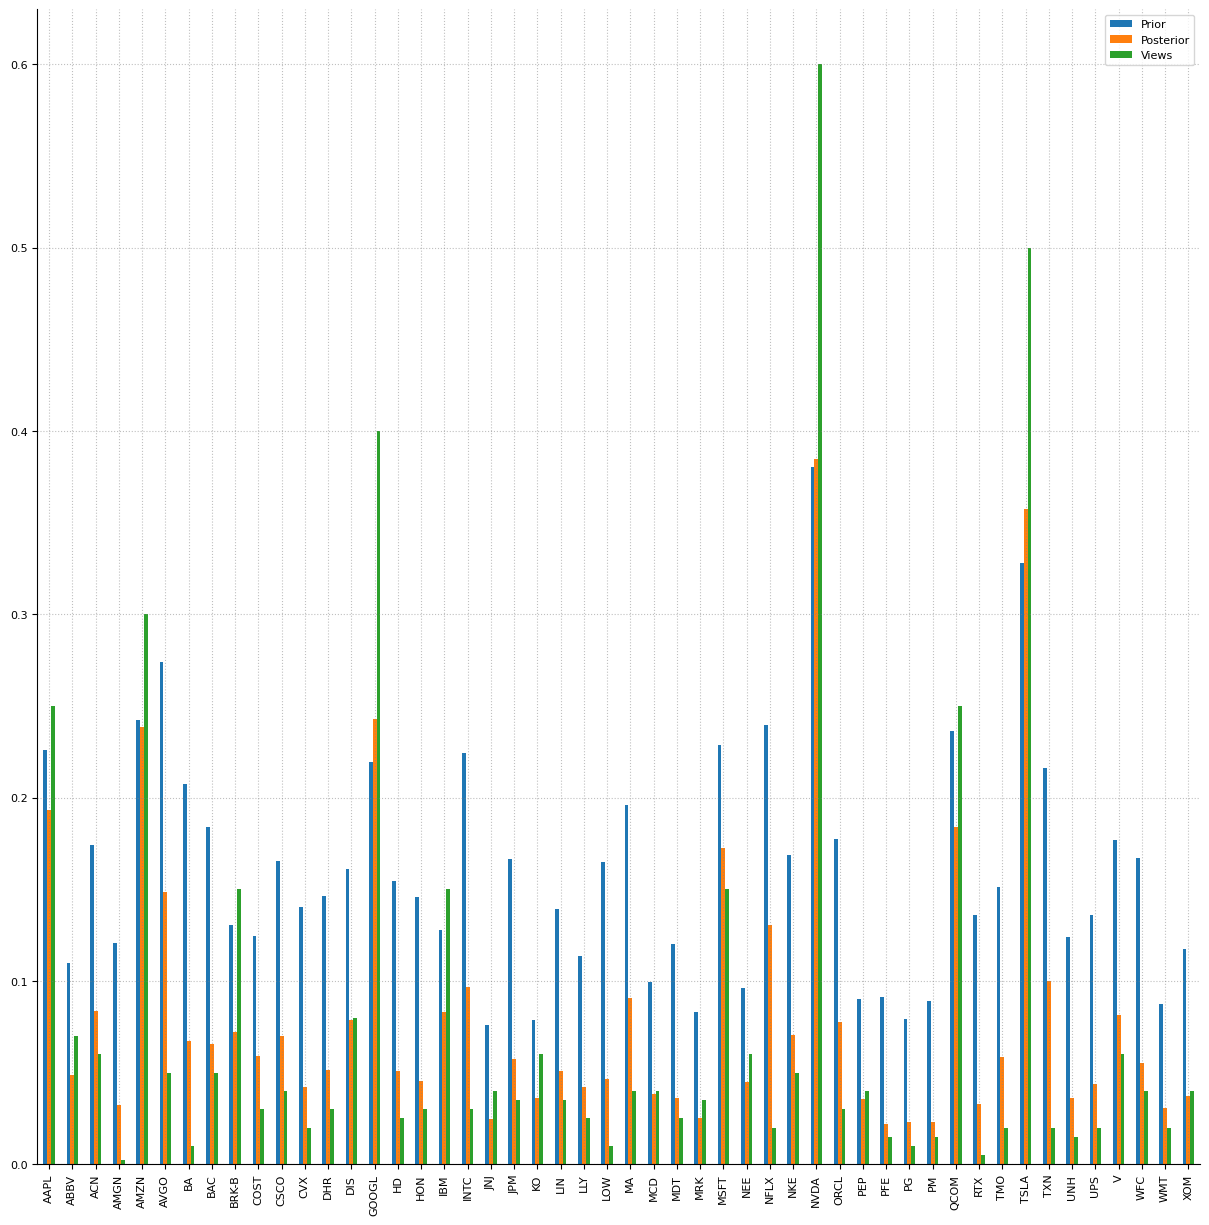

In [39]:
rets_df.plot.bar(figsize=(15,15));

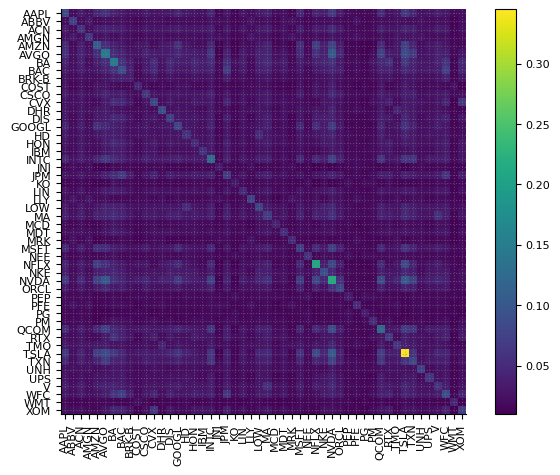

In [40]:
S_bl=bl.bl_cov()
plotting.plot_covariance(S_bl);

# Portfolio Allocation 1

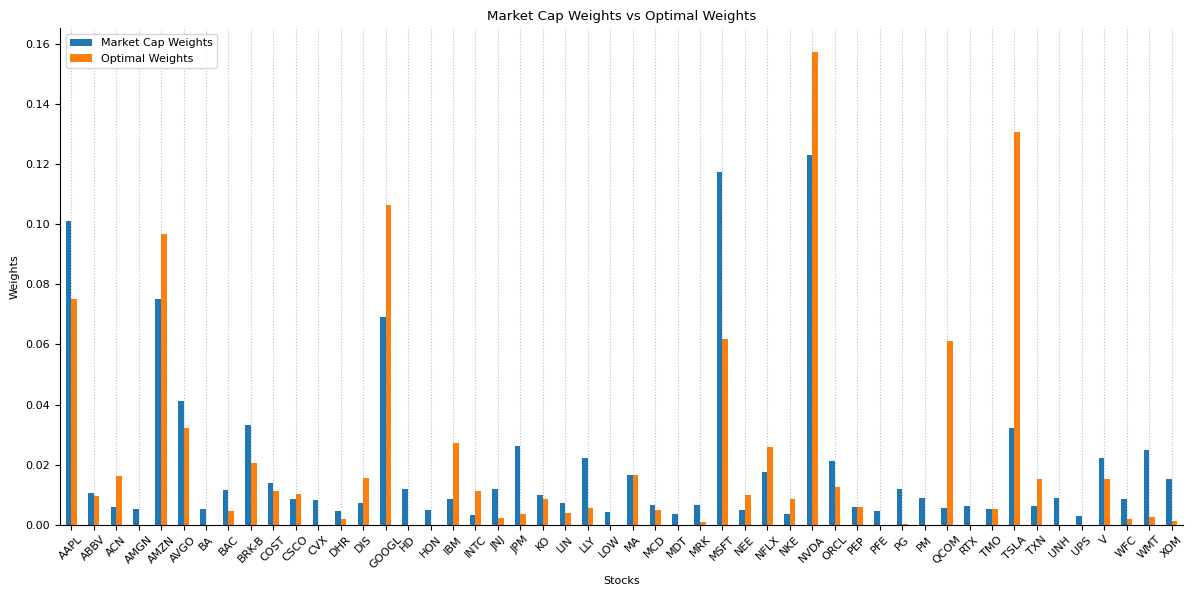

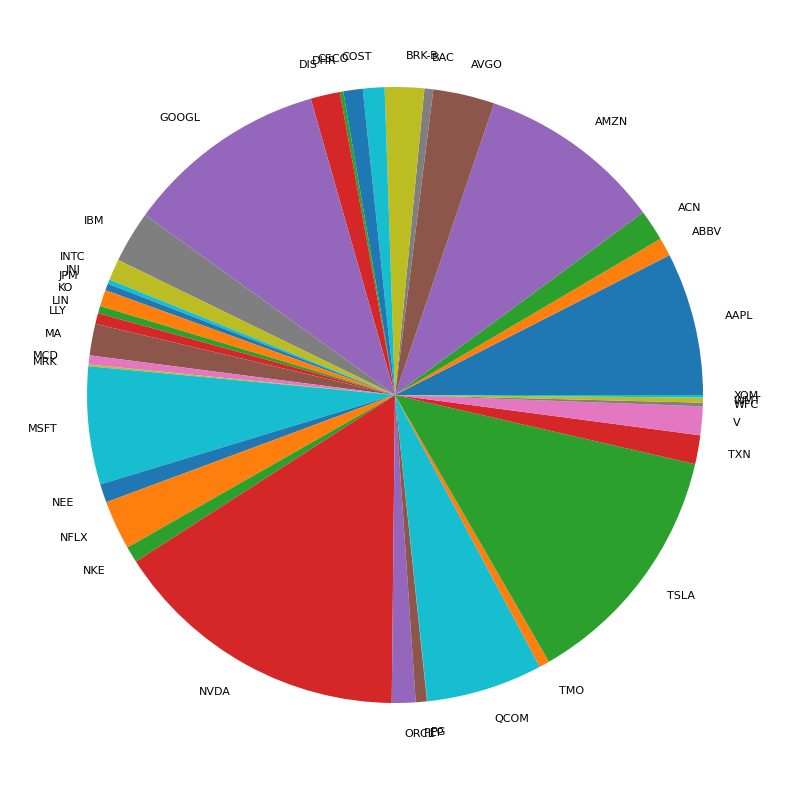

In [41]:
weights1=calculate_weights(ret_bl,S_bl)
alloc1,left_over1=discrete_allocation(weights1)
plot_weights(weights1,mcaps)
print("\n")
plot_pie(weights1)

In [42]:
calculate_performance(alloc1,prices)

Expected Portfolio Return: 33.51%
Portfolio Volatility: 128.69
Sharpe Ratio: 0.24


**View confidences**

In this, we provide two ways to construct the uncertainty matrix. The first is Idzorek's method. It allows us to specify a vector/list of percentage confidences.

In [43]:
confidences = [
    0.6, 0.8, 0.7, 0.7, 0.6, 0.9, 0.5, 0.4, 0.2, 0.35, 0.6, 0.15, 0.25,
    0.3, 0.5, 0.7, 0.8, 0.9, 0.6, 0.3, 0.2, 0.35, 0.4, 0.7, 0.2, 0.25,
    0.8, 0.4, 0.7, 0.3, 0.6, 0.4, 0.5, 0.9, 0.6, 0.3, 0.2, 0.35, 0.25,
    0.7, 0.1, 0.4, 0.3, 0.2, 0.5, 0.8, 0.3, 0.6, 0.4, 0.2
]

In [44]:
K=len(confidences)
K

50

**Purpose of the Code**

It allows us to combine market equilibrium returns (the "prior") with our own views to produce a new set of expected returns (the "posterior"), which can then be used for portfolio optimization.

In [46]:
bl=BlackLittermanModel(S,pi=market_prior,absolute_views=viewdict,omega="idzorek",view_confidences=confidences)

In [45]:
# Posterior estimate of returns
ret_bl=bl.bl_returns()

In [47]:
rets_df=pd.DataFrame([market_prior, ret_bl,pd.Series(viewdict)],
             index=["Prior","Posterior","Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.226006,0.193180,0.2500
ABBV,0.109778,0.048467,0.0700
ACN,0.174396,0.083562,0.0600
AMGN,0.120769,0.032391,0.0025
AMZN,0.242381,0.238389,0.3000
AVGO,0.274107,0.148404,0.0500
BA,0.207236,0.067065,0.0100
BAC,0.183804,0.065485,0.0500
BRK-B,0.130333,0.072283,0.1500
COST,0.124738,0.059131,0.0300


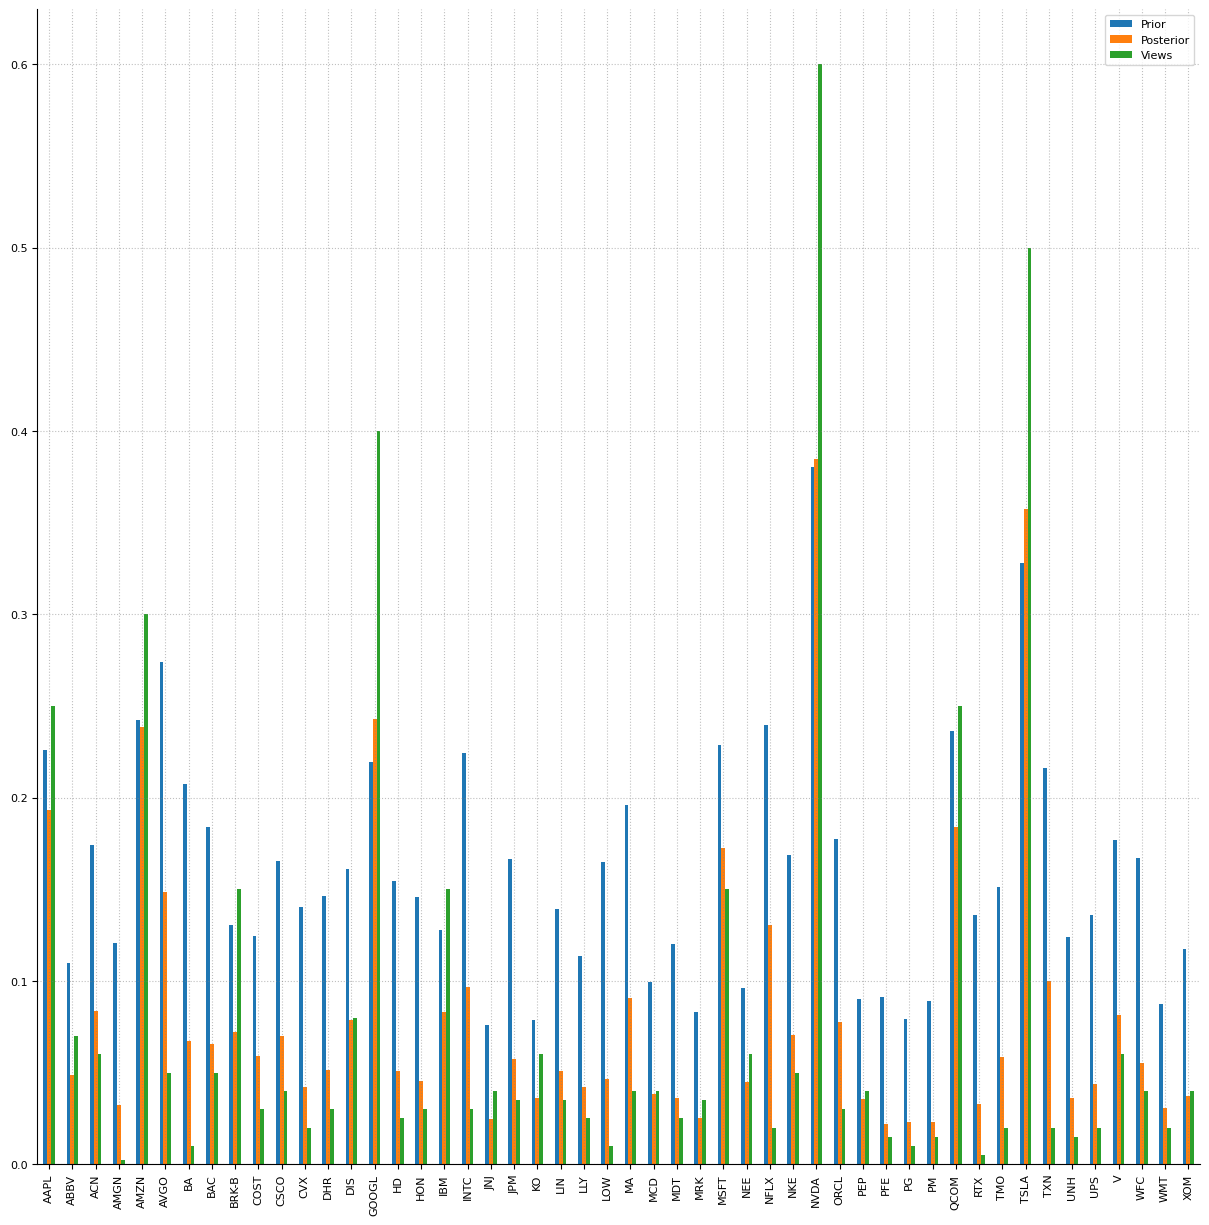

In [48]:
rets_df.plot.bar(figsize=(15,15));

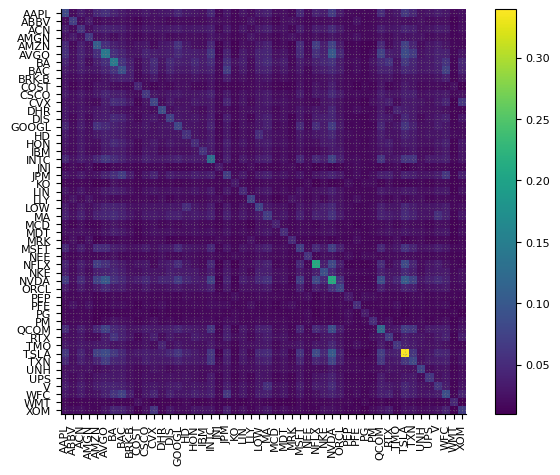

In [49]:
S_bl=bl.bl_cov()
plotting.plot_covariance(S_bl);

# Portfolio Allocation 2


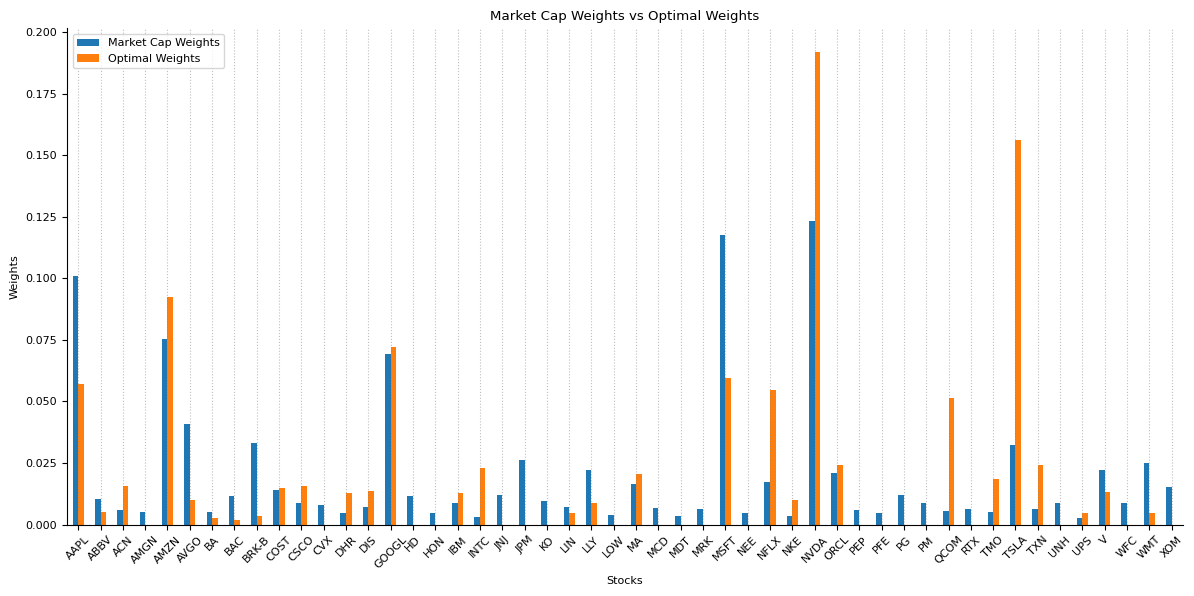

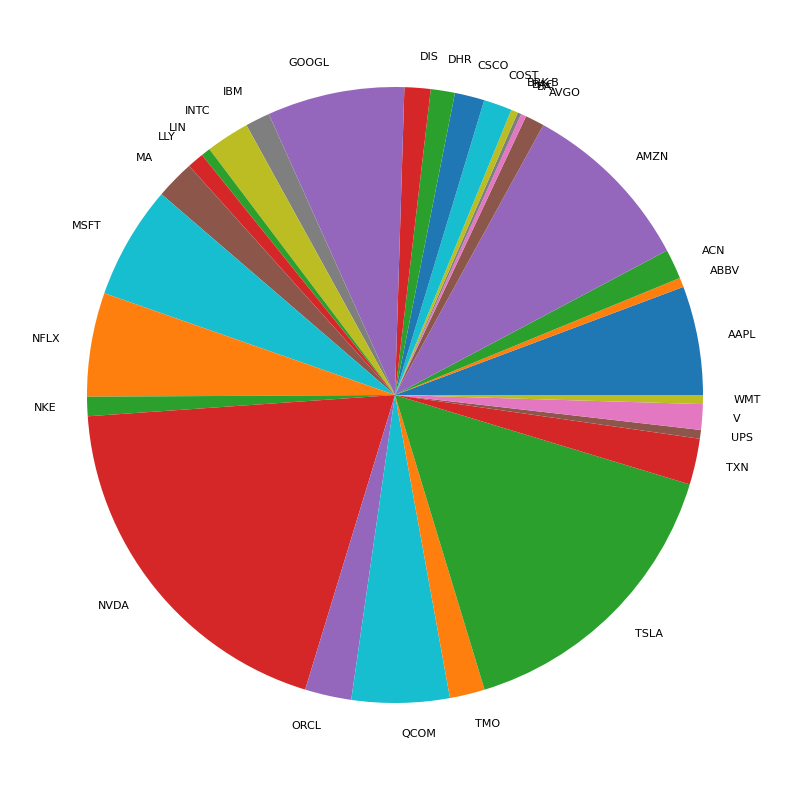

In [144]:
weights2=calculate_weights(ret_bl,S_bl)
alloc2,left_over2=discrete_allocation(weights2)
plot_weights(weights2,mcaps)
print("\n")
plot_pie(weights2)

In [145]:
calculate_performance(alloc2,prices)

Expected Portfolio Return: 36.10%
Portfolio Volatility: 135.01
Sharpe Ratio: 0.25


omega represents the uncertainty (covariance matrix) associated with the investor's views.

Idzorek Method:

The Idzorek method adjusts the uncertainty in the investor's views (omega) based on the confidence levels provided.
It allows for a more intuitive specification of confidence, translating confidence levels into a covariance matrix of view errors.

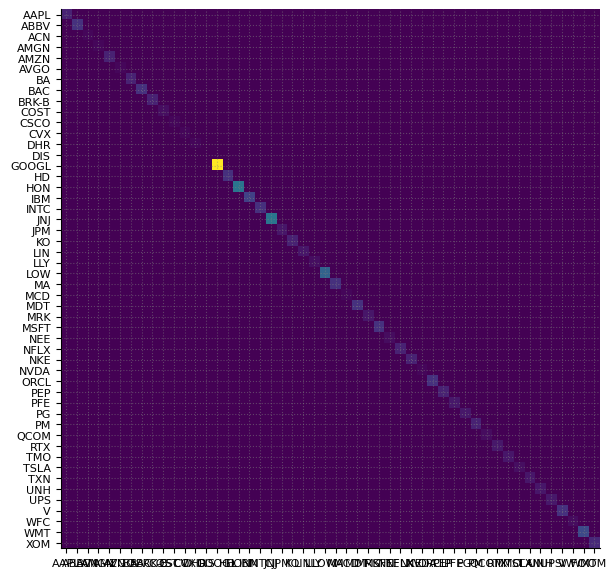

In [146]:
fig,ax=plt.subplots(figsize=(7,7))
im=ax.imshow(bl.omega)

ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [147]:
np.diag(bl.omega)

array([0.015625, 0.0225  , 0.0025  , 0.0025  , 0.015625, 0.0025  ,
       0.015625, 0.0225  , 0.015625, 0.005625, 0.0025  , 0.0025  ,
       0.0025  , 0.0004  , 0.16    , 0.0225  , 0.0625  , 0.030625,
       0.0225  , 0.0625  , 0.01    , 0.015625, 0.01    , 0.005625,
       0.050625, 0.0225  , 0.0025  , 0.0225  , 0.01    , 0.0225  ,
       0.005625, 0.015625, 0.015625, 0.0025  , 0.0225  , 0.015625,
       0.01    , 0.01    , 0.015625, 0.005625, 0.01    , 0.01    ,
       0.005625, 0.01    , 0.01    , 0.01    , 0.0225  , 0.005625,
       0.0361  , 0.018225])

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

These intervals represent ranges within which we expect the return of an asset to lie 68% of the time.

In [148]:
intervals = [
    (0, 0.25), (0.5, 0.8), (0.15, 0.25), (0.15, 0.25), (0, 0.25), (0.15, 0.25),
    (0, 0.25), (0.1, 0.4), (-0.1, 0.15), (-0.05, 0.1), (0.15, 0.25), (-0.1, 0),
    (0.1, 0.2), (0.08, 0.12), (0.1, 0.9), (0, 0.3), (0.25, 0.75), (0.2, 0.55),
    (0.05, 0.35), (-0.1, 0.4), (0.1, 0.3), (0.2, 0.45), (0.1, 0.3), (0.05, 0.2),
    (-0.05, 0.4), (0.2, 0.5), (0.15, 0.25), (0.1, 0.4), (0.15, 0.35), (-0.1, 0.2),
    (0.1, 0.25), (-0.05, 0.2), (0.05, 0.3), (0.15, 0.25), (0.1, 0.4), (0, 0.25),
    (-0.05, 0.15), (0.2, 0.4), (0.05, 0.3), (0.1, 0.25), (0.2, 0.4), (0.15, 0.35),
    (0.05, 0.2), (0.1, 0.3), (0.15, 0.35), (0.05, 0.25), (0.1, 0.4), (0.15, 0.3),
    (0.12, 0.5), (0.08, 0.35)
]

In [149]:
K=len(intervals)
K

50

In [150]:
variances=[]
for lb,ub in intervals:
    sigma=(ub-lb)/2
    variances.append(sigma**2)

print(variances)
omega=np.diag(variances)

[0.015625, 0.022500000000000006, 0.0025000000000000005, 0.0025000000000000005, 0.015625, 0.0025000000000000005, 0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.0625, 0.030625000000000006, 0.0225, 0.0625, 0.009999999999999998, 0.015625, 0.009999999999999998, 0.0056250000000000015, 0.050625, 0.0225, 0.0025000000000000005, 0.022500000000000006, 0.009999999999999998, 0.022500000000000006, 0.005625, 0.015625, 0.015625, 0.0025000000000000005, 0.022500000000000006, 0.015625, 0.010000000000000002, 0.010000000000000002, 0.015625, 0.005625, 0.010000000000000002, 0.009999999999999998, 0.0056250000000000015, 0.009999999999999998, 0.009999999999999998, 0.010000000000000002, 0.022500000000000006, 0.005625, 0.0361, 0.018224999999999995]


# Posterior estimates

Given the inputs, we can compute a posterior estimate of returns

In [104]:
bl=BlackLittermanModel(S,pi="market",market_caps=mcaps,risk_aversion=delta,absolute_views=viewdict,omega=omega)

In [105]:
# Posterior estimate of returns
ret_bl=bl.bl_returns()

We can visualise how this compares to the prior and our views

In [106]:
rets_df=pd.DataFrame([market_prior, ret_bl,pd.Series(viewdict)],
             index=["Prior","Posterior","Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.226006,0.189260,0.2500
ABBV,0.109778,0.046900,0.0700
ACN,0.174396,0.095358,0.0600
AMGN,0.120769,0.042310,0.0025
AMZN,0.242381,0.265838,0.3000
AVGO,0.274107,0.131941,0.0500
BA,0.207236,0.085309,0.0100
BAC,0.183804,0.070281,0.0500
BRK-B,0.130333,0.052277,0.1500
COST,0.124738,0.074897,0.0300


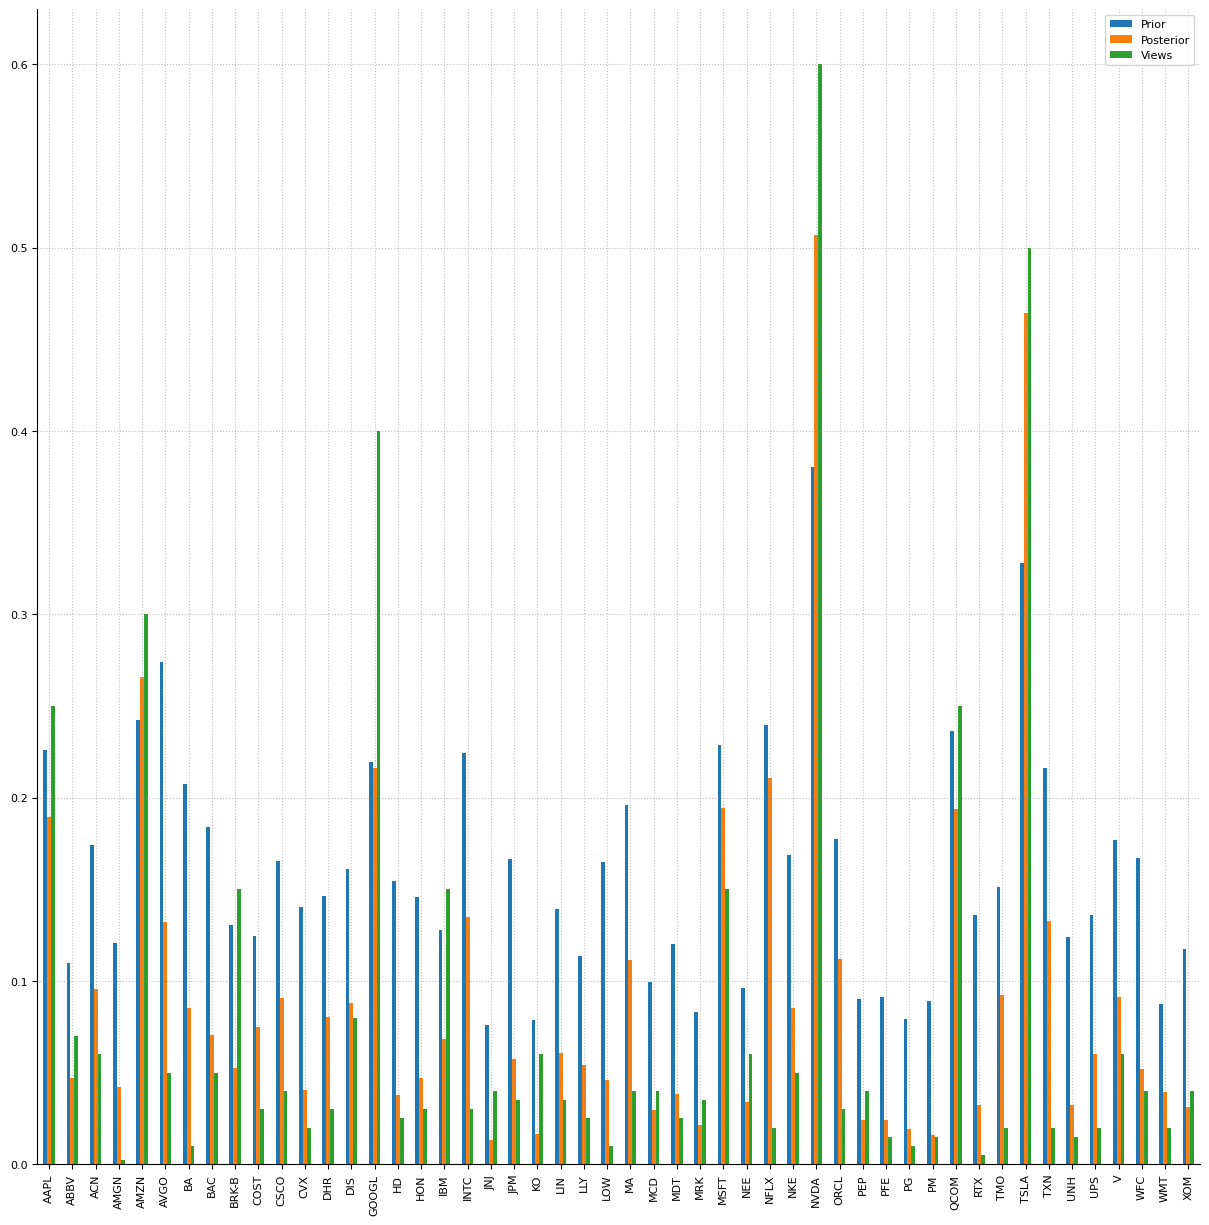

In [107]:
rets_df.plot.bar(figsize=(15,15));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate.

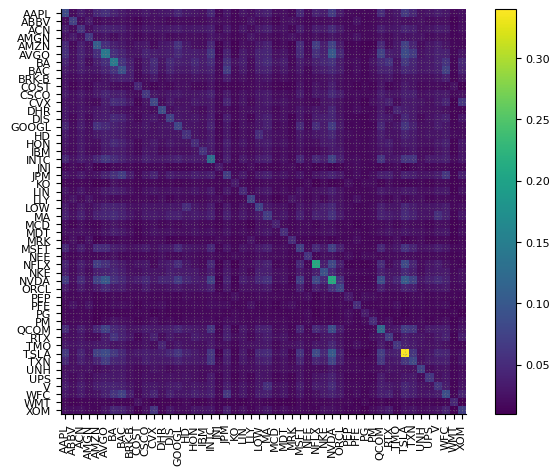

In [108]:
S_bl=bl.bl_cov()
plotting.plot_covariance(S_bl);

# Portfolio Allocation 3


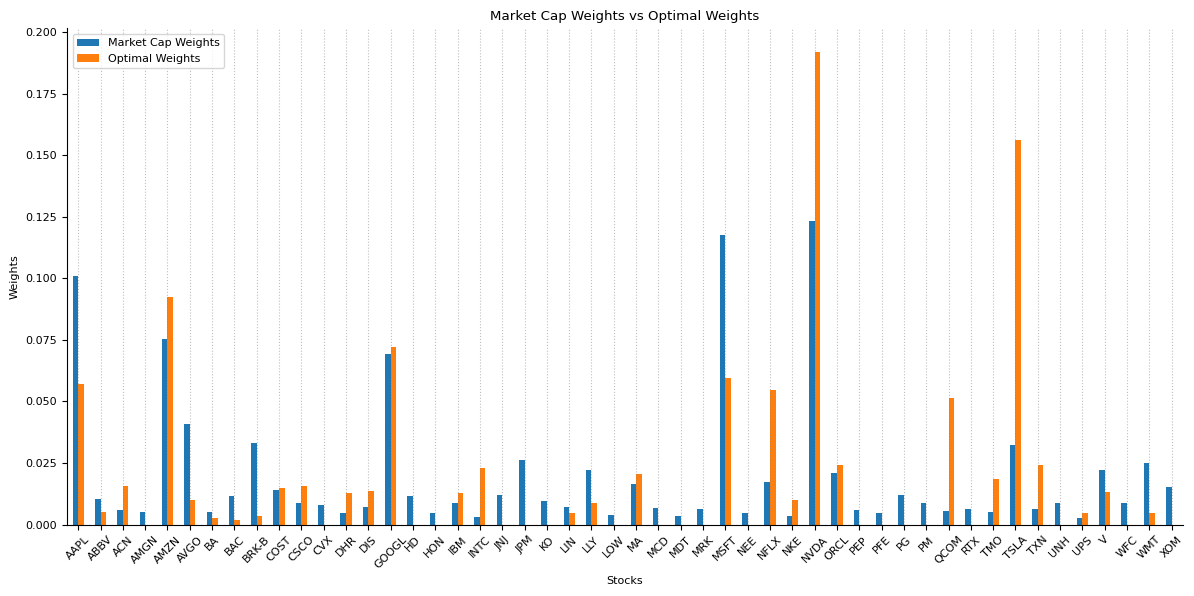

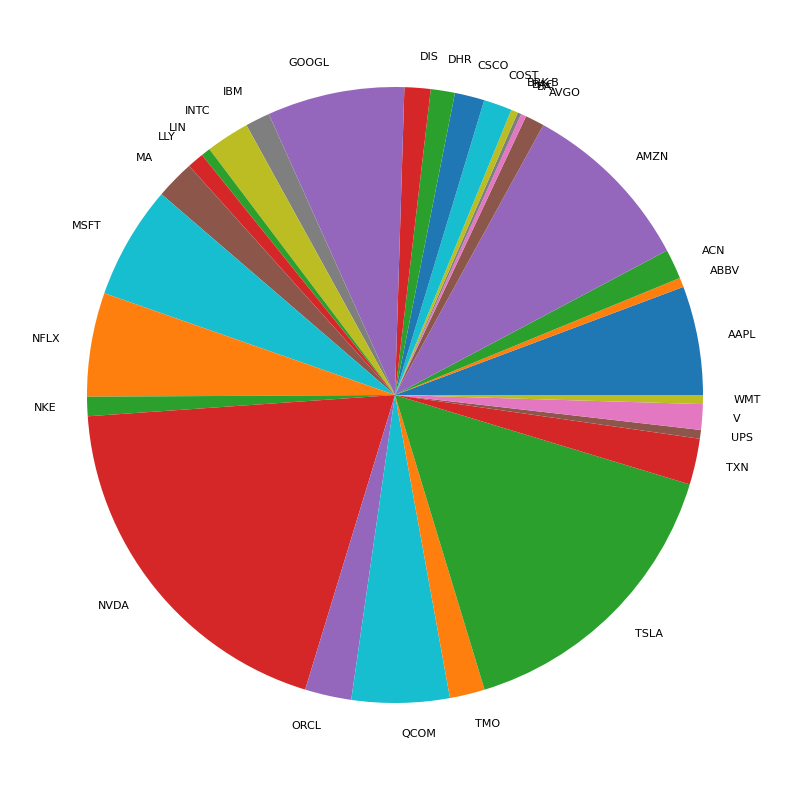

In [109]:
weights3=calculate_weights(ret_bl,S_bl)
alloc3,left_over3=discrete_allocation(weights3)
plot_weights(weights3,mcaps)
print("\n")
plot_pie(weights3)

In [110]:
calculate_performance(alloc3,prices)

Expected Portfolio Return: 36.10%
Portfolio Volatility: 135.01
Sharpe Ratio: 0.25


# Integrating the Fama French Model into the Black Litterman Model

In [111]:
def fama_french_expected_returns(betas_df,market_return,smb_return,hml_return,rf):
    expected_returns=[]
    annualized_returns=[]
    for _, row in betas_df.iterrows():
        alpha=row['alpha']
        beta_mkt=row['beta_mkt']
        beta_smb=row['beta_smb']
        beta_hml=row['beta_hml']

        expected_return=(rf+alpha+
                           beta_mkt*(market_return-rf)+
                           beta_smb*smb_return+
                           beta_hml*hml_return)
        expected_returns.append(expected_return)
        annualized_returns.append(((1+expected_return)**12)-1)

    return pd.Series(expected_returns,index=betas_df.index),pd.Series(annualized_returns,index=betas_df.index)

In [112]:
rf2=ff_factors_subset['RF'].mean()/100
market_return=ff_factors_subset['Mkt-RF'].mean()/100 # Market return
smb_return=ff_factors_subset['SMB'].mean()/100 # SMB factor
hml_return=ff_factors_subset['HML'].mean()/100 # HML factor

In [113]:
betas.head(5)

,alpha,beta_mkt,beta_smb,beta_hml
AAPL,0.007955,1.250939,-0.266892,-0.520495
ABBV,0.009087,0.754001,0.002351,0.220757
ACN,0.000754,1.148768,-0.213471,-0.242000
AMGN,0.005370,0.727237,-0.205868,0.020113
AMZN,0.006405,1.326237,-0.248815,-0.952880


In [114]:
expected_ff_returns,annualized_ff_returns=fama_french_expected_returns(betas,market_return,smb_return,hml_return,rf2)

**Monthly Expected Returns for each stock using the Fama French Model in decimal**

In [115]:
expected_ff_returns

,0
AAPL,0.021971
ABBV,0.017164
ACN,0.013401
AMGN,0.013631
AMZN,0.021645
AVGO,0.032424
BA,0.012463
BAC,0.012828
BRK-B,0.011213
COST,0.017548


**Annualized Expected Returns for each stock using the Fama French Model in decimal**

In [116]:
annualized_ff_returns

,0
AAPL,0.297971
ABBV,0.226568
ACN,0.173205
AMGN,0.176413
AMZN,0.293002
AVGO,0.466559
BA,0.160250
BAC,0.165271
BRK-B,0.143166
COST,0.232131


In [117]:
S_annual=S*12
bl2=BlackLittermanModel(S_annual,
                         pi=annualized_ff_returns,  # Use Fama-French expected returns
                         market_caps=mcaps,
                         risk_aversion=delta,
                         absolute_views=viewdict,
                         omega=omega)

In [118]:
# Posterior estimate of returns
ret_bl2=bl2.bl_returns()

In [119]:
rets_df2=pd.DataFrame([market_prior,ret_bl2,pd.Series(viewdict)],
             index=["Prior","Posterior","Views"]).T
rets_df2

,Prior,Posterior,Views
AAPL,0.226006,0.224826,0.2500
ABBV,0.109778,0.075957,0.0700
ACN,0.174396,0.064436,0.0600
AMGN,0.120769,0.014003,0.0025
AMZN,0.242381,0.292275,0.3000
AVGO,0.274107,0.066213,0.0500
BA,0.207236,0.025070,0.0100
BAC,0.183804,0.058768,0.0500
BRK-B,0.130333,0.080469,0.1500
COST,0.124738,0.072058,0.0300


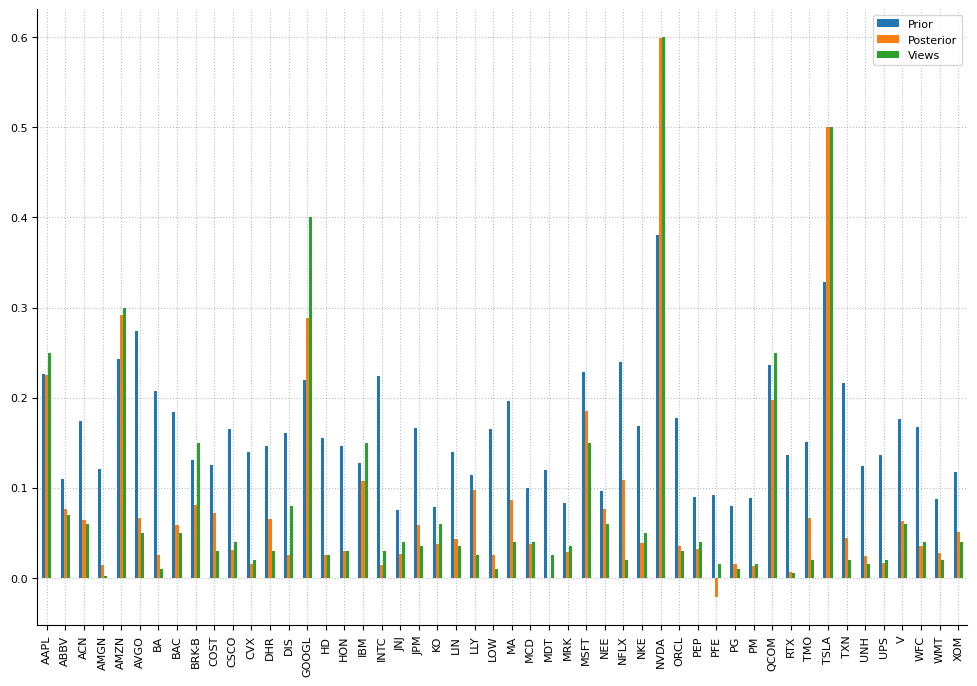

In [120]:
rets_df2.plot.bar(figsize=(12,8));

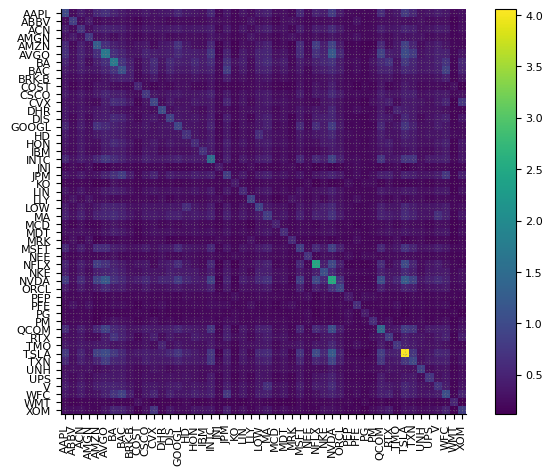

In [121]:
S_bl2=bl2.bl_cov()
plotting.plot_covariance(S_bl2);

# Portfolio Allocation 4

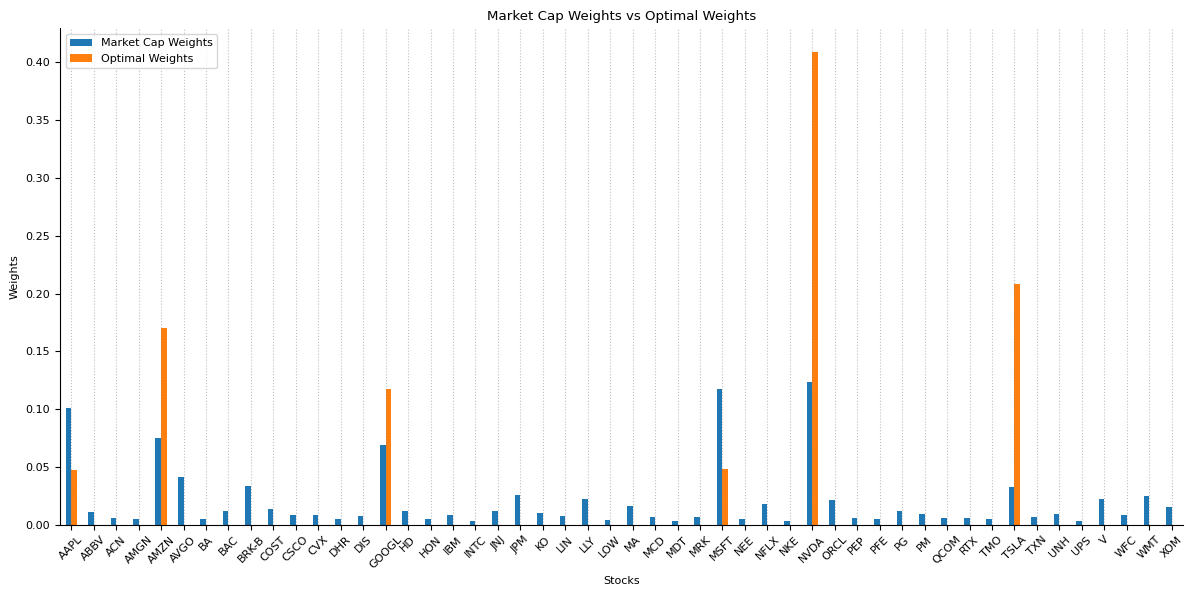

In [151]:
weights4=calculate_weights(ret_bl2,S_bl2)
alloc4,left_over4=discrete_allocation(weights4)
plot_weights(weights4,mcaps)
print("\n")

In [152]:
calculate_performance(alloc4,prices)

Expected Portfolio Return: 46.56%
Portfolio Volatility: 243.20
Sharpe Ratio: 0.18
